In [2]:
#T005 · Compound clustering（Clustering with the Butina algorithm）

In [3]:
#Load data and calculate fingerprints （the data is prepared and fingerprints are calculated）
import time
import random
from pathlib import Path

import pandas as pd
import numpy
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
#from teachopencadd.utils import seed_everything

#seed_everything()  # fix seed to get deterministic outputs
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [4]:
# Load and have a look into data
# Filtered data taken from **Talktorial T002**
compound_df = pd.read_csv(
    HERE / "../T000_template/data/MCL1_compounds_lipinski.csv",
    index_col=0,
)
print("Dataframe shape:", compound_df.shape)
compound_df.head()

Dataframe shape: (416, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL4535151,0.2,nM,CN(C)C(=O)CO[C@H]1/C=C/CCN(C)C(=O)C[C@](O)(C(=...,9.698970,"<img data-content=""rdkit/molecule"" src=""data:i...",785.322512,9,2,3.2313,True
2,CHEMBL4553660,0.2,nM,CN1CC/C=C/[C@H](OCCN2CCOCC2)[C@@H]2CC[C@H]2CN2...,9.698970,"<img data-content=""rdkit/molecule"" src=""data:i...",813.353812,10,2,3.4753,True
3,CHEMBL4464768,0.3,nM,CN1CC/C=C/[C@H](OCCNCC(F)(F)CO)[C@@H]2CC[C@H]2...,9.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",837.334969,10,4,3.3603,True
4,CHEMBL4446369,0.3,nM,CN1CC/C=C/[C@H](OCCN2CC(F)(F)C2)[C@@H]2CC[C@H]...,9.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",819.324404,9,2,4.0940,True
6,CHEMBL4539543,0.3,nM,COC1CN(CCO[C@H]2/C=C/CCN(C)C(=O)C[C@](O)(C(=O)...,9.522879,"<img data-content=""rdkit/molecule"" src=""data:i...",813.353812,10,2,3.4737,True


In [5]:
# Create molecules from SMILES and store in array
compounds = []
# .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
for _, chembl_id, smiles in compound_df[["molecule_chembl_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x7fe5256c9a60>, 'CHEMBL4535151'),
 (<rdkit.Chem.rdchem.Mol at 0x7fe5256c9e20>, 'CHEMBL4553660'),
 (<rdkit.Chem.rdchem.Mol at 0x7fe5256c9d60>, 'CHEMBL4464768'),
 (<rdkit.Chem.rdchem.Mol at 0x7fe5256c9be0>, 'CHEMBL4446369'),
 (<rdkit.Chem.rdchem.Mol at 0x7fe5256c9b20>, 'CHEMBL4539543')]

In [6]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT

Number of compounds converted: 416
Fingerprint length per compound: 2048


In [7]:
#Tanimoto similarity and distance matrix
#The identification of potential cluster centroids （define functions to calculate the Tanimoto similarity and distance matrix）
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [8]:
# Example: Calculate single similarity of two fingerprints
# NBVAL_CHECK_OUTPUT
sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.99, distance: 0.01


In [9]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fingerprints)[0:5]

[0.010852713178294615,
 0.04925373134328359,
 0.03915662650602414,
 0.046337817638266054,
 0.03619909502262442]

In [10]:
# Side note: That looked like a list and not a matrix.
# But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)
# NBVAL_CHECK_OUTPUT

Elements in the triangular matrix (86320) == tanimoto_distance_matrix(fingerprints) (86320)


In [11]:
#Clustering molecules: Centroids and exclusion spheres
#Define a clustering function.
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [12]:
#Cluster the molecules based on their fingerprint similarity.
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.3)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)
# NBVAL_CHECK_OUTPUT

total # clusters:  154
# clusters with only 1 compound:  116
# clusters with >5 compounds:  14
# clusters with >25 compounds:  2
# clusters with >100 compounds:  0


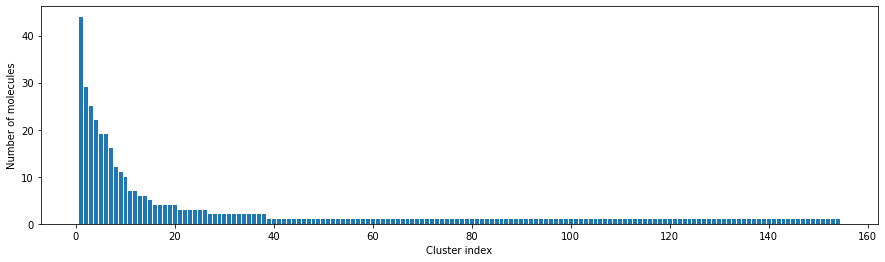

In [13]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

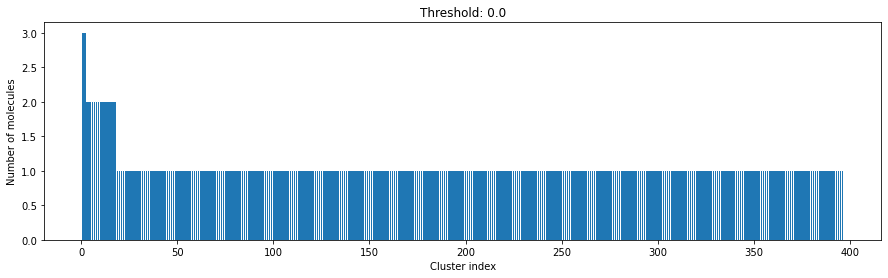

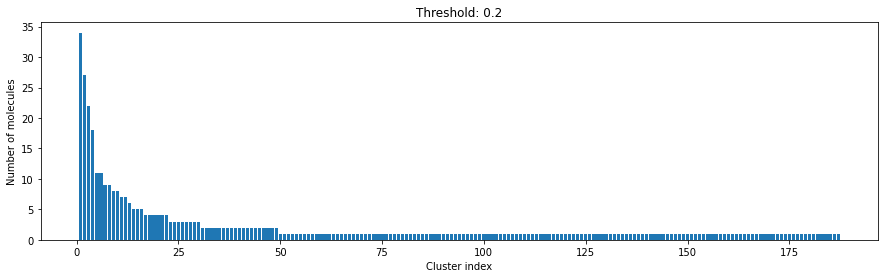

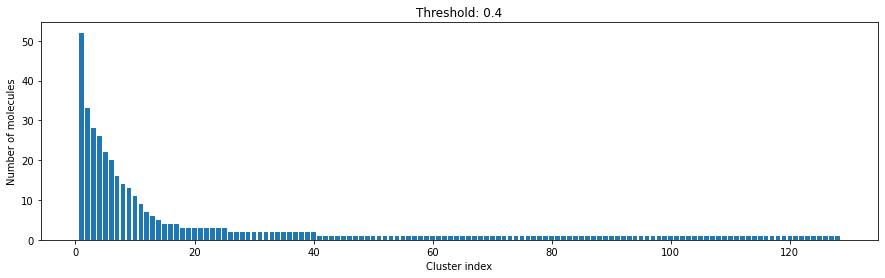

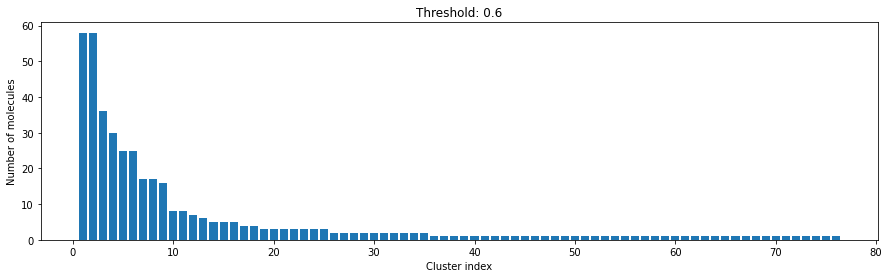

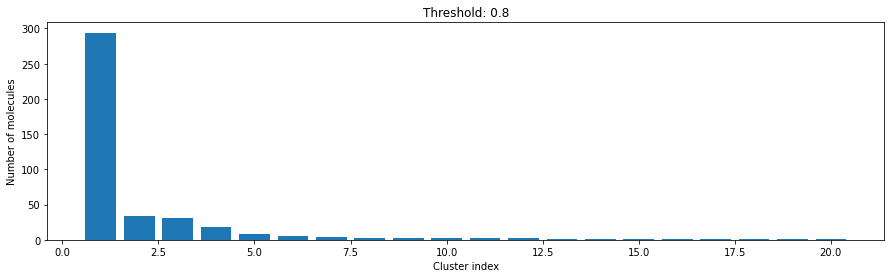

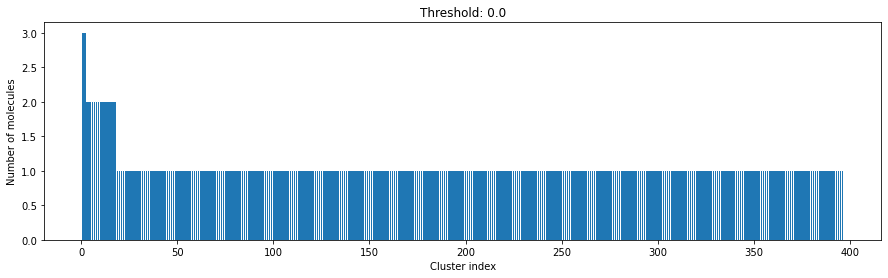

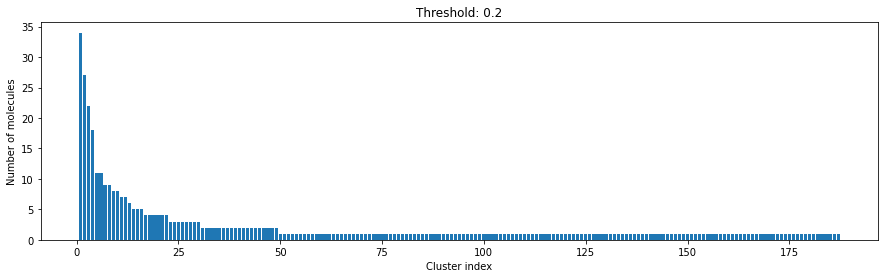

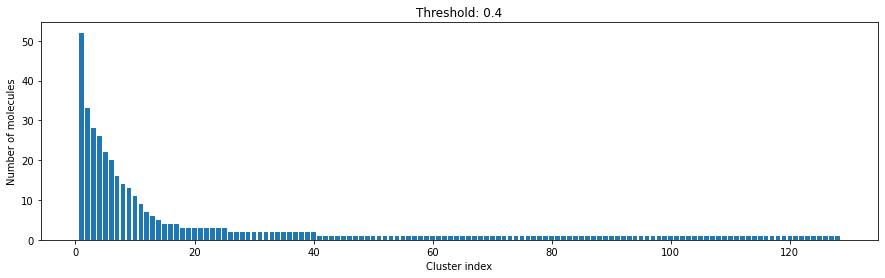

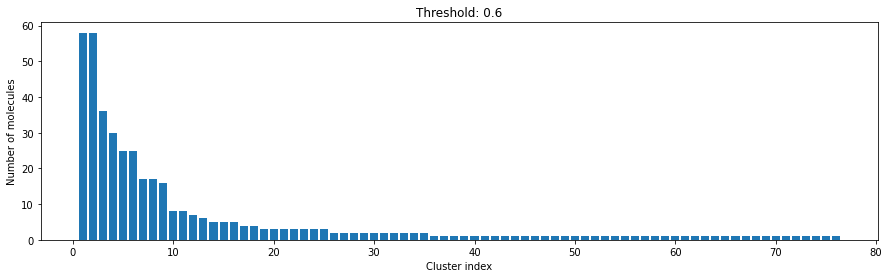

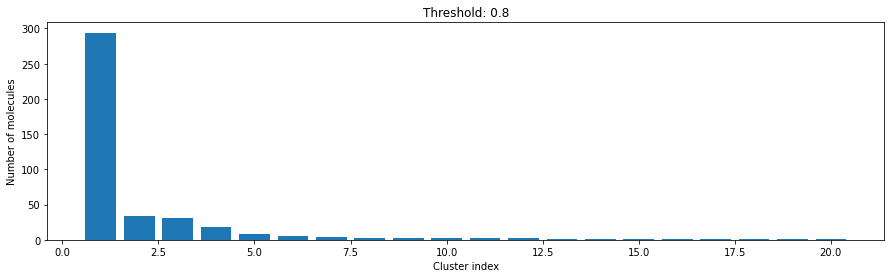

In [14]:
#pick a reasonable cutoff
for cutoff in numpy.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

Number of clusters: 187 from 416 molecules at distance cut-off 0.20
Number of molecules in largest cluster: 34
Similarity between two random points in same cluster: 0.99
Similarity between two random points in different cluster: 0.13


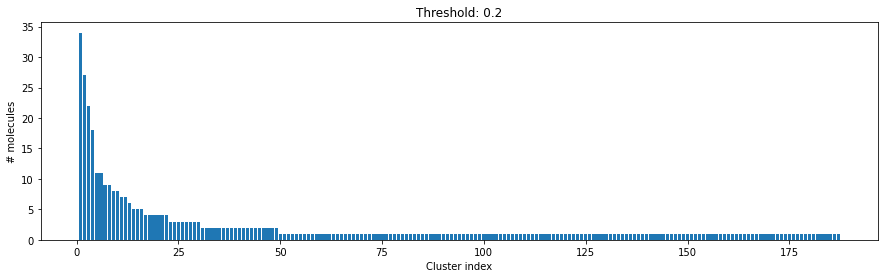

In [15]:
#decided to choose a distance threshold of 0.2. There are not many singletons and the cluster sizes don't have an extreme but smooth distribution
cutoff = 0.2
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
fig.savefig(
    DATA / f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

Ten molecules from largest cluster:


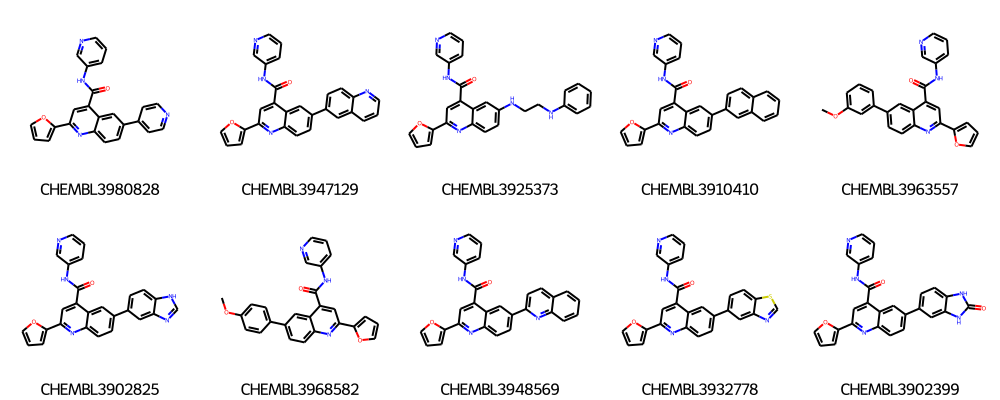

In [16]:
#Visualizing the clusters （10 examples from largest cluster）
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

In [17]:
# Save molecules from largest cluster so other talktorials can use it
sdf_path = str(DATA / "molecule_set_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters[0]:
    mol, label = compounds[index]
    # Add label to metadata
    mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()

Ten molecules from second largest cluster:


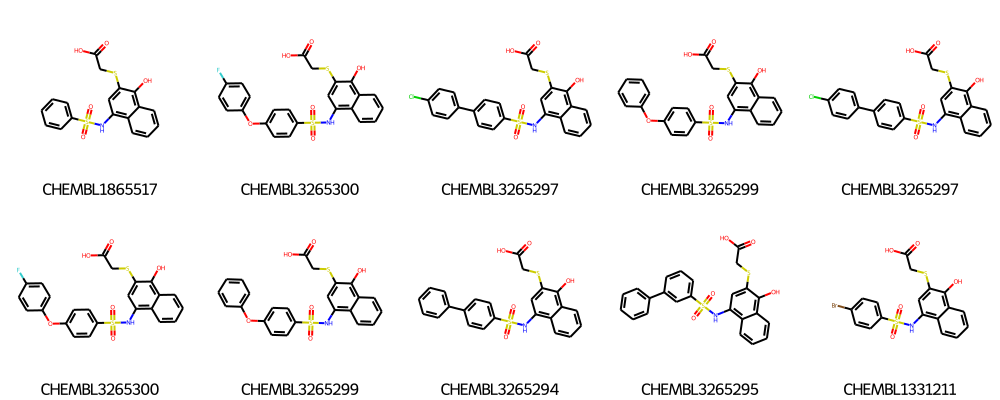

In [18]:
print("Ten molecules from second largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][:10]],
    legends=[compounds[i][1] for i in clusters[1][:10]],
    molsPerRow=5,
)

In [ ]:
#The first ten molecules in the respective clusters look indeed similar to each other and many share a common scaffold (visually detected)

In [19]:
#Save cluster centers from first 3 clusters as SVG file
# Generate image
img = Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(0, 3)],
    legends=[f"Cluster {i}" for i in range(1, 4)],
    subImgSize=(200, 200),
    useSVG=True,
)

# Patch RAW svg data: convert non-transparent to transparent background and set font size
molsvg = img.data.replace("opacity:1.0", "opacity:0.0").replace("12px", "20px")

# Save altered SVG data to file
with open(DATA / "cluster_representatives.svg", "w") as f:
    f.write(molsvg)

In [20]:
#Intra-cluster Tanimoto similarities
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [21]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

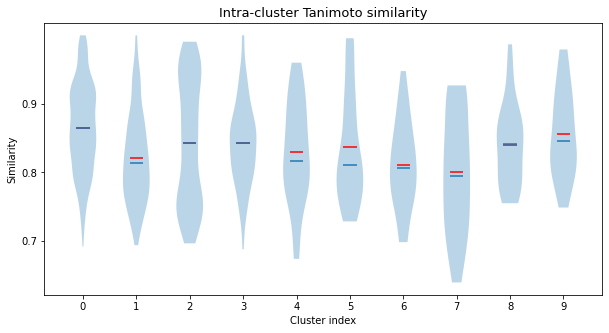

In [22]:
# Violin plot with intra-cluster similarity

fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(numpy.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue

In [23]:
#Picking the final list of compounds （ensure the diversity for a smaller set of compounds which are proposed for testing in a confirmatory assay）
#take the cluster centroid from each cluster (i.e. the first molecule of each cluster) and then for each cluster (starting with the largest one) we take the 10 molecules

# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))
# NBVAL_CHECK_OUTPUT

Number of cluster centers: 187


In [24]:
# Sort the molecules within a cluster based on their similarity
# to the cluster center and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    sorted_fingerprints = [rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)

In [25]:
#Picking the final list of compounds

# Count selected molecules, pick cluster centers first
selected_molecules = cluster_centers.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
pending = 1000 - len(selected_molecules)
while pending > 0 and index < len(sorted_clusters):
    # Take indices of sorted clusters
    tmp_cluster = sorted_clusters[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if sorted_clusters[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5 * len(tmp_cluster)) + 1
    if num_compounds > pending:
        num_compounds = pending
    # Write picked molecules and their structures into list of lists called picked_fps
    selected_molecules += [compounds[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    pending = 1000 - len(selected_molecules)
print("# Selected molecules:", len(selected_molecules))
# NBVAL_CHECK_OUTPUT

# Selected molecules: 324


In [26]:
#Bonus: analysis of run times （play with the size of the dataset and see how the Butina clustering run time changes）

# Reuse old dataset
sampled_mols = compounds.copy()

In [28]:
# Helper function for time computation
def measure_runtime(sampled_mols):
    start_time = time.time()
    sampled_fingerprints = [rdkit_gen.GetFingerprint(m) for m, idx in sampled_mols]
    # Run the clustering with the dataset
    sampled_clusters = cluster_fingerprints(sampled_fingerprints, cutoff=0.3)
    return time.time() - start_time
len(sampled_mols)

416

In [30]:
sample_sizes = [100, 200, 300, 400]
runtimes = []
# Take random samples with replacement
for size in sample_sizes:
    time_taken = measure_runtime(random.sample(sampled_mols, size))
    print(f"Dataset size {size}, time {time_taken:4.2f} seconds")
    runtimes.append(time_taken)

Dataset size 100, time 0.07 seconds
Dataset size 200, time 0.14 seconds
Dataset size 300, time 0.22 seconds
Dataset size 400, time 0.30 seconds


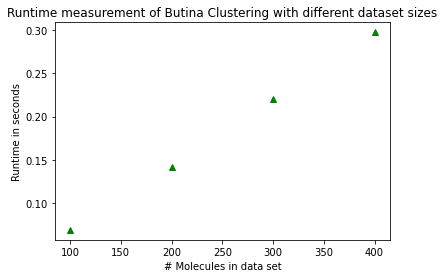

In [31]:
fig, ax = plt.subplots()
ax.set_title("Runtime measurement of Butina Clustering with different dataset sizes")
ax.set_xlabel("# Molecules in data set")
ax.set_ylabel("Runtime in seconds")
ax.plot(sample_sizes, runtimes, "g^");